Q, – przyjęte do obliczeń natężenie ruchu na pasie ruchu [P/h]

S – natężenie nasycenia [P/hz]

C – przepustowość pasa ruchu [P/h]

Y – stopień nasycenia [-]

X – stopień obciążenia (wykorzystania przepustowości) pasa ruchu [-]


S (Natężenie nasycenia) - maksymalna liczba pojazdów, która mogłaby przejechać przez pas ruchu w ciągu godziny przy ciągłym, 100% zielonym świetle. Zależy od charakterystyki pojazdów i geometrii pasa. Zazwyczaj jest to wartość wejściowa lub kalibracyjna symulacji, a nie wynik.

C (Przepustowość pasa ruchu) - maksymalna liczba pojazdów, która może przejechać przez pas ruchu w ciągu godziny w danych warunkach cyklu sygnalizacji świetlnej (uwzględniając czas zielony, czerwony, żółty). Można ją oszacować na podstawie symulacji, ale nie jest to standardowe wyjście. Często oblicza się ją ze wzoru C=S⋅(G/T), gdzie G to efektywny czas zielony, a T to długość cyklu.

Y (Stopień nasycenia) - stosunek natężenia ruchu (Q) do przepustowości (C): Y=Q/C. Można go obliczyć, jeśli mamy oszacowane Q i C.

X (Stopień obciążenia)- stosunek natężenia ruchu (Q) do praktycznej przepustowości. W wielu kontekstach jest traktowany podobnie lub identycznie jak stopień nasycenia (Y).

D (Średnie straty czasu) - różnica między czasem podróży w warunkach zatłoczenia a czasem podróży przy swobodnym przepływie. Można go ekstrahować z danych śledzenia pojazdów z symulacji, ale wymaga to dostępu do szczegółowych trajektorii i zdefiniowania prędkości swobodnej.

Z (Wskaźnik zatrzymań) - średnia liczba zatrzymań na pojazd. Również możliwy do uzyskania z danych śledzenia pojazdów, analizując zmiany prędkości do zera.

Lk (Długość kolejki) - zasięg kwantyla 95% maksymalnej kolejki. Można estymować z danych symulacji, śledząc liczbę zatrzymanych pojazdów w czasie.

PSR (Poziom swobody ruchu) - jakościowa ocena warunków ruchu, często oparta na innych metrykach, takich jak prędkość, gęstość czy straty czasu. Nie jest to bezpośredni wynik symulacji, ale raczej interpretacja wyników.


Dane symulacji po agregacji:
  Relacja  Q_sym
0      AL  370.0
1     AWP  415.0
2     BLW   45.0
3      BP  193.0
4    CLWP  523.0
5    DLWP   49.0

{' PORÓWNANIE WYNIKÓW SYMULACJI I DANYCH REFERENCYJNYCH ':=^80}
Relacja  Q_ref  Q_sym  Różnica_Q  Procentowa_Różnica_Q  Y_ref  Y_sym  Różnica_Y  Procentowa_Różnica_Y
     AL    375 370.00      -5.00                 -1.33   0.23   0.82       0.60                363.82
    AWP    430 415.00     -15.00                 -3.49   0.28   0.41       0.13                147.95
    BLW     70  45.00     -25.00                -35.71   0.14   0.10      -0.04                 71.43
     BP    196 193.00      -3.00                 -1.53   0.15   0.27       0.12                182.35
   CLWP    546 523.00     -23.00                 -4.21   1.09   1.07      -0.02                 98.01
   DLWP    247  49.00    -198.00                -80.16   1.48   0.19      -1.29                 12.73

{' METRYKI JAKOŚCI ':=^80}
Średni błąd bezwzględny natężenia ruchu (MAE

<Figure size 1200x600 with 0 Axes>

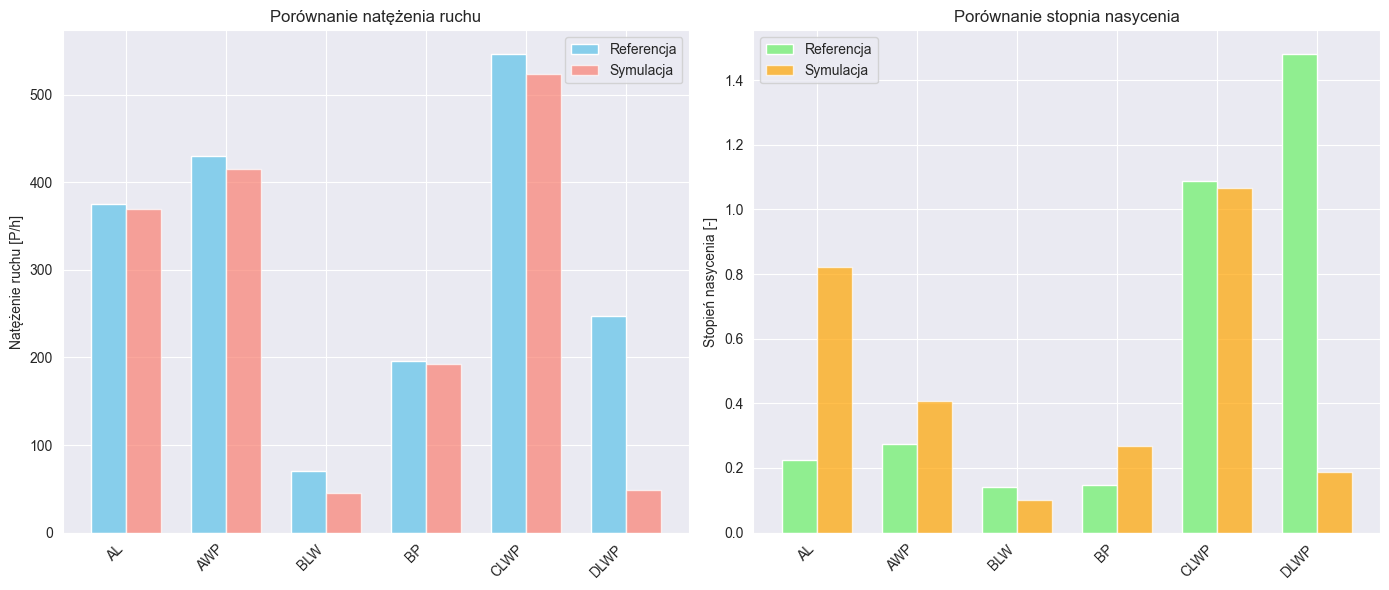

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ścieżka do pliku z wynikami analizy przepływu ruchu
plik_wyniki = 'traffic_flow_analysis.csv'

# Dane referencyjne z tabeli (zawierają Y i X, więc możemy je porównać, jeśli oszacujemy Y)
tabela_dane = {
    'AL': {'Q': 375, 'S': 1800, 'C': 400, 'Y': 0.226, 'X': 0.984, 'G': 25, 'T': 100}, # Założone S, G, T
    'AWP': {'Q': 430, 'S': 1700, 'C': 900, 'Y': 0.275, 'X': 0.436, 'G': 60, 'T': 100}, # Założone S, G, T
    'BLW': {'Q': 70, 'S': 1500, 'C': 150, 'Y': 0.140, 'X': 0.584, 'G': 30, 'T': 100}, # Założone S, G, T
    'BP': {'Q': 196, 'S': 1600, 'C': 600, 'Y': 0.147, 'X': 0.334, 'G': 45, 'T': 100},   # Założone S, G, T
    'CLWP': {'Q': 546, 'S': 1400, 'C': 450, 'Y': 1.089, 'X': 1.089, 'G': 35, 'T': 100}, # Założone S, G, T
    'DLWP': {'Q': 247, 'S': 1300, 'C': 200, 'Y': 1.480, 'X': 1.480, 'G': 20, 'T': 100}  # Założone S, G, T
}

df_referencyjne_raw = pd.DataFrame.from_dict(tabela_dane, orient='index')
df_referencyjne_raw.index.names = ['Relacja']
df_referencyjne = df_referencyjne_raw[['Q', 'S', 'C', 'Y', 'X', 'G', 'T']].copy()
df_referencyjne = df_referencyjne.reset_index()
df_referencyjne.rename(columns={'Relacja': 'Kierunek'}, inplace=True)
df_referencyjne['Relacja'] = df_referencyjne['Kierunek']

# Odczyt danych symulacji z pliku traffic_flow_analysis.csv
try:
    # Zakładamy, że separatory to przecinek
    df_symulacja_csv = pd.read_csv(plik_wyniki, sep=',', engine='python', comment='#')

    # Usunięcie wiodących i końcowych spacji z nazw kolumn
    df_symulacja_csv.columns = df_symulacja_csv.columns.str.strip()

    # Wybranie potrzebnych kolumn
    if 'Relacja' in df_symulacja_csv.columns and 'P/h' in df_symulacja_csv.columns:
        df_symulacja = df_symulacja_csv[['Relacja', 'P/h']].copy()
        df_symulacja = df_symulacja[df_symulacja['Relacja'] != 'Unknown'].copy() # Usunięcie wiersza z 'Unknown'
        df_symulacja.rename(columns={'P/h': 'Q_sym'}, inplace=True)

        # Agregacja relacji
        def aggregate_relations(df):
            aggregated_data = {}
            for index, row in df.iterrows():
                relacja = row['Relacja']
                q_sym = row['Q_sym']
                if relacja.startswith('A') and relacja[1:] in ['W', 'P']:
                    if 'AWP' not in aggregated_data:
                        aggregated_data['AWP'] = 0
                    aggregated_data['AWP'] += q_sym
                elif relacja.startswith('B') and relacja[1:] in ['L', 'W']:
                    if 'BLW' not in aggregated_data:
                        aggregated_data['BLW'] = 0
                    aggregated_data['BLW'] += q_sym
                elif relacja.startswith('C') and relacja[1:] in ['W', 'P', 'L']:
                    if 'CLWP' not in aggregated_data:
                        aggregated_data['CLWP'] = 0
                    aggregated_data['CLWP'] += q_sym
                elif relacja.startswith('D') and relacja[1:] in ['W', 'P', 'L']:
                    if 'DLWP' not in aggregated_data:
                        aggregated_data['DLWP'] = 0
                    aggregated_data['DLWP'] += q_sym
                else:
                    aggregated_data[relacja] = q_sym
            return pd.DataFrame(list(aggregated_data.items()), columns=['Relacja', 'Q_sym'])

        df_symulacja_agregowana = aggregate_relations(df_symulacja.copy())

        print("\nDane symulacji po agregacji:")
        print(df_symulacja_agregowana)

        # Połączenie danych referencyjnych i zagregowanych wyników symulacji po 'Relacja'
        df_porownanie = pd.merge(df_symulacja_agregowana, df_referencyjne, on='Relacja', how='left')

        # Obliczenie przepustowości (C_sym) i stopnia nasycenia (Y_sym) z symulacji (jeśli G i T są dostępne)
        df_porownanie['S'] = df_porownanie['Relacja'].map(df_referencyjne.set_index('Relacja')['S'])
        df_porownanie['G'] = df_porownanie['Relacja'].map(df_referencyjne.set_index('Relacja')['G'])
        df_porownanie['T'] = df_porownanie['Relacja'].map(df_referencyjne.set_index('Relacja')['T'])

        df_porownanie['C_sym'] = df_porownanie.apply(lambda row: row['S'] * (row['G'] / row['T']) if pd.notna(row['S']) and pd.notna(row['G']) and pd.notna(row['T']) and row['T'] > 0 else np.nan, axis=1)
        df_porownanie['Y_sym'] = df_porownanie['Q_sym'] / df_porownanie['C_sym']

        # Obliczenie różnic
        df_porownanie['Różnica_Q'] = df_porownanie['Q_sym'] - df_porownanie['Q']
        df_porownanie['Procentowa_Różnica_Q'] = (df_porownanie['Różnica_Q'] / df_porownanie['Q']) * 100
        df_porownanie['Różnica_Y'] = df_porownanie['Y_sym'] - df_porownanie['Y']
        df_porownanie['Procentowa_Różnica_Y'] = (df_porownanie['Y_sym'] / df_porownanie['Y']) * 100

        # Prezentacja wyników
        print("\n{' PORÓWNANIE WYNIKÓW SYMULACJI I DANYCH REFERENCYJNYCH ':=^80}")
        pd.set_option('display.max_rows', None)
        pd.set_option('display.width', 120)
        pd.set_option('display.float_format', '{:.2f}'.format)

        df_wyniki = df_porownanie[['Relacja', 'Q', 'Q_sym', 'Różnica_Q', 'Procentowa_Różnica_Q', 'Y', 'Y_sym', 'Różnica_Y', 'Procentowa_Różnica_Y']].copy()
        df_wyniki.rename(columns={'Q': 'Q_ref', 'Y': 'Y_ref'}, inplace=True)
        print(df_wyniki.to_string(index=False))

        # Metryki jakości
        mae_q = np.mean(np.abs(df_wyniki['Różnica_Q'].dropna()))
        mape_q = np.mean(np.abs(df_wyniki['Procentowa_Różnica_Q'].dropna()))
        mae_y = np.mean(np.abs(df_wyniki['Różnica_Y'].dropna()))
        mape_y = np.mean(np.abs(df_wyniki['Procentowa_Różnica_Y'].dropna()))

        print("\n{' METRYKI JAKOŚCI ':=^80}")
        print(f"Średni błąd bezwzględny natężenia ruchu (MAE_Q): {mae_q:.2f} P/h")
        print(f"Średni bezwzględny błąd procentowy natężenia ruchu (MAPE_Q): {mape_q:.2f}%")
        print(f"Średni błąd bezwzględny stopnia nasycenia (MAE_Y): {mae_y:.3f}")
        print(f"Średni bezwzględny błąd procentowy stopnia nasycenia (MAPE_Y): {mape_y:.3f}%")

        # Wykresy porównawcze
        plt.figure(figsize=(12, 6))

        # Wykresy porównawcze
        szerokosc_slupka = 0.35
        x_pozycja = np.arange(len(df_wyniki['Relacja']))

        plt.figure(figsize=(14, 6))

        # Porównanie natężenia ruchu
        plt.subplot(1, 2, 1)
        plt.bar(x_pozycja - szerokosc_slupka/2, df_wyniki['Q_ref'], szerokosc_slupka, label='Referencja', color='skyblue')
        plt.bar(x_pozycja + szerokosc_slupka/2, df_wyniki['Q_sym'], szerokosc_slupka, label='Symulacja', color='salmon', alpha=0.7)
        plt.ylabel('Natężenie ruchu [P/h]')
        plt.title('Porównanie natężenia ruchu')
        plt.xticks(x_pozycja, df_wyniki['Relacja'], rotation=45, ha='right')
        plt.legend()
        plt.tight_layout()

        # Porównanie stopnia nasycenia
        plt.subplot(1, 2, 2)
        plt.bar(x_pozycja - szerokosc_slupka/2, df_wyniki['Y_ref'], szerokosc_slupka, label='Referencja', color='lightgreen')
        plt.bar(x_pozycja + szerokosc_slupka/2, df_wyniki['Y_sym'], szerokosc_slupka, label='Symulacja', color='orange', alpha=0.7)
        plt.ylabel('Stopień nasycenia [-]')
        plt.title('Porównanie stopnia nasycenia')
        plt.xticks(x_pozycja, df_wyniki['Relacja'], rotation=45, ha='right')
        plt.legend()
        plt.tight_layout()

        plt.show()
        plt.show()

    else:
        print(f"Błąd: Nie znaleziono kolumny 'Relacja' lub 'P/h' w pliku {plik_wyniki}.")

except FileNotFoundError:
    print(f"Błąd: Nie znaleziono pliku {plik_wyniki}.")
except Exception as e:
    print(f"Wystąpił błąd podczas odczytu pliku CSV: {e}")